In [1]:
# import libraries
import re
import pandas as pd

import folium
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.probability import FreqDist

In [2]:
df=pd.read_csv('/content/naukri_data_science_jobs_india.csv')
print('Successfully read file into Dataframe...')

Successfully read file into Dataframe...


In [3]:
# concise summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job_Role            12000 non-null  object
 1   Company             12000 non-null  object
 2   Location            12000 non-null  object
 3   Job Experience      12000 non-null  object
 4   Skills/Description  12000 non-null  object
dtypes: object(5)
memory usage: 468.9+ KB


In [4]:
# shape of dataframe
print('Number of Rows: {}'.format(df.shape[0]))
print('Number of Columns: {}'.format(df.shape[1]))

Number of Rows: 12000
Number of Columns: 5


In [5]:
# first five rows
df.head()

,Job_Role,Company,Location,Job Experience,Skills/Description
0,Senior Data Scientist,UPL,"Bangalore/Bengaluru, Mumbai (All Areas)",3-6,"python, MLT, statistical modeling, machine lea..."
1,Senior Data Scientist,Walmart,Bangalore/Bengaluru,5-9,"Data Science, Machine learning, Python, Azure,..."
2,Applied Data Scientist / ML Senior Engineer (P...,SAP India Pvt.Ltd,Bangalore/Bengaluru,5-10,"Python, IT Skills, Testing, Cloud, Product Man..."
3,Data Scientist,UPL,"Bangalore/Bengaluru, Mumbai (All Areas)",1-4,"python, machine learning, Data Science, data a..."
4,Data Scientist,Walmart,Bangalore/Bengaluru,4-8,"IT Skills, Python, Data Science, Machine Learn..."


In [6]:
# user defined functions

def MinExp(txt):
    num = int(txt.split('-')[0])
    return num

def MaxExp(txt):
    num = int(txt.split('-')[1])
    return num

def preprocess_location(loc):
    loc=re.split('\(', loc)[0].strip()
    loc=re.sub('New Delhi','Delhi',loc)
    return loc

In [7]:
# top 10 jobs
job_10=df['Job_Role'].value_counts()[:10].rename_axis('Job Role').reset_index(name='Count')
job_10.style.background_gradient(cmap='Greys')

,Job Role,Count
0,Data Engineer,580
1,Data Scientist,505
2,Data Analyst,353
3,Senior Technical Lead (Data Engineer),276
4,Senior Data Engineer,197
5,Business Analyst,197
6,Senior Data Scientist,97
7,Azure Data Engineer,80
8,Data Engineer: Data Integration,75
9,Big Data Engineer,71


In [8]:
# plot
dataframe = pd.DataFrame()

for job in job_10['Job Role']:
    df1 = df[df['Job_Role']==job]
    skill = [skill.lower() for skills in df1['Skills/Description'] for skill in skills.split(', ') if skill != 'IT Skills']
    fdist = FreqDist(skill)
    fdist_df=pd.DataFrame(list(dict(fdist).items()), columns=['skill', 'count'])
    fdist_df= fdist_df.sort_values(by='count', ascending=False)[:10]
    fdist_df = fdist_df.assign(job=job)
    dataframe=dataframe.append(fdist_df)

    # Creating sunburst chart
fig = px.sunburst(dataframe,
                  path=['job', 'skill'],
                  values='count'
                 )

fig.update_layout(
    autosize=False,
    title_text='Top Jobs and the Required Skills',
    title_x=0.5,
    width=1080,
    height=720)

# Display the figure
fig.show()

In [10]:
# values in location column
df['Location'][:10]

0    Bangalore/Bengaluru, Mumbai (All Areas)
1                        Bangalore/Bengaluru
2                        Bangalore/Bengaluru
3    Bangalore/Bengaluru, Mumbai (All Areas)
4                        Bangalore/Bengaluru
5                        Bangalore/Bengaluru
6                        Bangalore/Bengaluru
7    Bangalore/Bengaluru, Mumbai (All Areas)
8                        Bangalore/Bengaluru
9                                    Chennai
Name: Location, dtype: object

0    Bangalore/Bengaluru, Mumbai (All Areas)
1                        Bangalore/Bengaluru
2                        Bangalore/Bengaluru
3    Bangalore/Bengaluru, Mumbai (All Areas)
4                        Bangalore/Bengaluru
5                        Bangalore/Bengaluru
6                        Bangalore/Bengaluru
7    Bangalore/Bengaluru, Mumbai (All Areas)
8                        Bangalore/Bengaluru
9                                    Chennai
Name: Location, dtype: object

In [11]:
## top 10 job locations

# splitting values and saving into a list
loc=df['Location'].tolist()
loc=[j.strip() for i in [j.strip() for i in loc for j in i.split(',')] for j in i.split('/')]

# count
fdist = FreqDist(loc)
loc_df=pd.DataFrame(list(dict(fdist).items()), columns=['location', 'job openings'])

# removing alternate names
for loc in ['Bengaluru','Secunderabad','Cochin','NCR','Gurugram']:
    loc_df=loc_df[loc_df['location']!=loc]
    
# applying function
loc_df['location']=loc_df['location'].apply(preprocess_location)
loc_df=loc_df.groupby('location').sum().reset_index(level=0)

# top 10 locations
loc_df=loc_df.sort_values(by='job openings',ascending=False)[:10]
loc_df.style.background_gradient(cmap='mako_r')

,location,job openings
17,Bangalore,4753
139,Pune,2047
73,Hyderabad,1960
116,Mumbai,1462
39,Chennai,1301
64,Gurgaon,1255
47,Delhi,782
128,Noida,545
98,Kolkata,291
2,Ahmedabad,222


In [12]:
# latitude and longitude of the locations
lat=[12.9716,18.5204,17.3850,19.0760,13.0827,28.4595,28.6139,28.5355,22.5726,23.0225]
lon=[77.5946,73.8567,78.4867,72.8777,80.2707,77.0266,77.2090,77.3910,88.3639,72.5714]

df1=loc_df.copy()
df1['lat']=lat
df1['lon']=lon

# title
loc = 'Top 10 Job Locations'
title_html = '''
             <h3 align="center" style="font-size:20px"><b>{}</b></h3>
             '''.format(loc)

# creating map
m = folium.Map(location=[20,78], tiles="OpenStreetMap", zoom_start=4.5)
m.get_root().html.add_child(folium.Element(title_html))
    
for i in range(0,len(df1)):
    # marking each location
    folium.Marker(
      location=[df1.iloc[i]['lat'], df1.iloc[i]['lon']],
      popup=df1.iloc[i]['location'],
      tooltip = df1.location.values[i],
      icon=folium.Icon(icon='info-sign', color="red"),
      draggable=False
   ).add_to(m)

# Show the map
m

In [13]:
# Top 10 demanding skills in data science jobs
skills=[j.lower() for i in df['Skills/Description'] for j in i.split(', ')]
fdist = FreqDist(skills)
skill_df=pd.DataFrame(fdist.items(), 
                      columns=['Skill', 'Frequency']
                    ).sort_values('Frequency', ascending=False)[:10]
skill_df.style.background_gradient()

,Skill,Frequency
0,python,3152
4,it skills,2907
3,machine learning,1780
20,data analysis,1614
47,sql,1525
22,big data,1396
23,computer science,1339
87,analytical,1306
8,data science,1288
15,cloud,1242


In [14]:
# plot

default_color = "grey"
colors = {"python": "crimson"}

color_discrete_map = {
    c: colors.get(c, default_color) 
    for c in skill_df.Skill.unique()}

fig = px.bar(skill_df, x='Frequency', y='Skill',color='Skill',orientation='h',color_discrete_map=color_discrete_map)
fig.update_layout(
    autosize=False,
    title_text='Top 10 Skills',
    title_x=0.5,
    width=900,
    height=600)

fig.show()

In [15]:
# number of companies available
df['Company'].nunique()

3507

In [16]:
# top 10 companies
df_company=df['Company'].value_counts()[:10].rename_axis('Company').reset_index(name='Job Openings')
df_company.style.background_gradient(cmap='binary')

,Company,Job Openings
0,Accenture,490
1,IBM,316
2,Infostretch solutions Pvt. Ltd.,304
3,Huquo Consulting Pvt. Ltd,295
4,Anicalls,115
5,BNY Mellon,103
6,Microsoft,92
7,Deutsche Bank,84
8,Career Infosystem,82
9,Serving Skill,76


In [17]:
## Companies and Jobs

dataframe = pd.DataFrame()

for company in df_company['Company']:
    df1 = df[df['Company']==company]
    jobs = [job for job in df1['Job_Role']]
    fdist = FreqDist(jobs)
    fdist_df=pd.DataFrame(list(dict(fdist).items()), columns=['jobs', 'count'])
    fdist_df= fdist_df.sort_values(by='count', ascending=False)[:5]
    fdist_df = fdist_df.assign(company=company)
    dataframe=dataframe.append(fdist_df)
    
dataframe.head()
    
# Creating sunburst chart
fig = px.sunburst(dataframe,
                  path=['company', 'jobs'])

fig.update_layout(
    autosize=False,
    title_text='Top Job Providers and Jobs',
    title_x=0.5,
    width=1000,
    height=720)

# Display the figure
fig.show()

In [18]:
# top 10 values in 'Job Experience'
df['Job Experience'].value_counts()[:10]

5-10    944
2-5     833
3-8     690
3-5     589
4-9     582
2-7     537
3-6     504
5-8     495
3-7     454
4-8     445
Name: Job Experience, dtype: int64

In [19]:
# outliers in 'Job Experience' column
lst=[]
for i in df['Job Experience']:
    c=False
    for j in i:
        if j.isalpha():
            c=True
    if c==True:
        lst.append(i)
        
lst

['12 May - 21 May',
 'B.Tech/B.E.',
 '16 May - 22 May',
 '18 May',
 '12 May - 21 May',
 '17 May - 26 May',
 '18 May']

In [20]:
# removing outliers
for j in lst:
    df=df[df['Job Experience'] != j]

In [21]:
# new features
df['Min. Exp.'] = df['Job Experience'].apply(MinExp)
df['Max. Exp.'] = df['Job Experience'].apply(MaxExp)

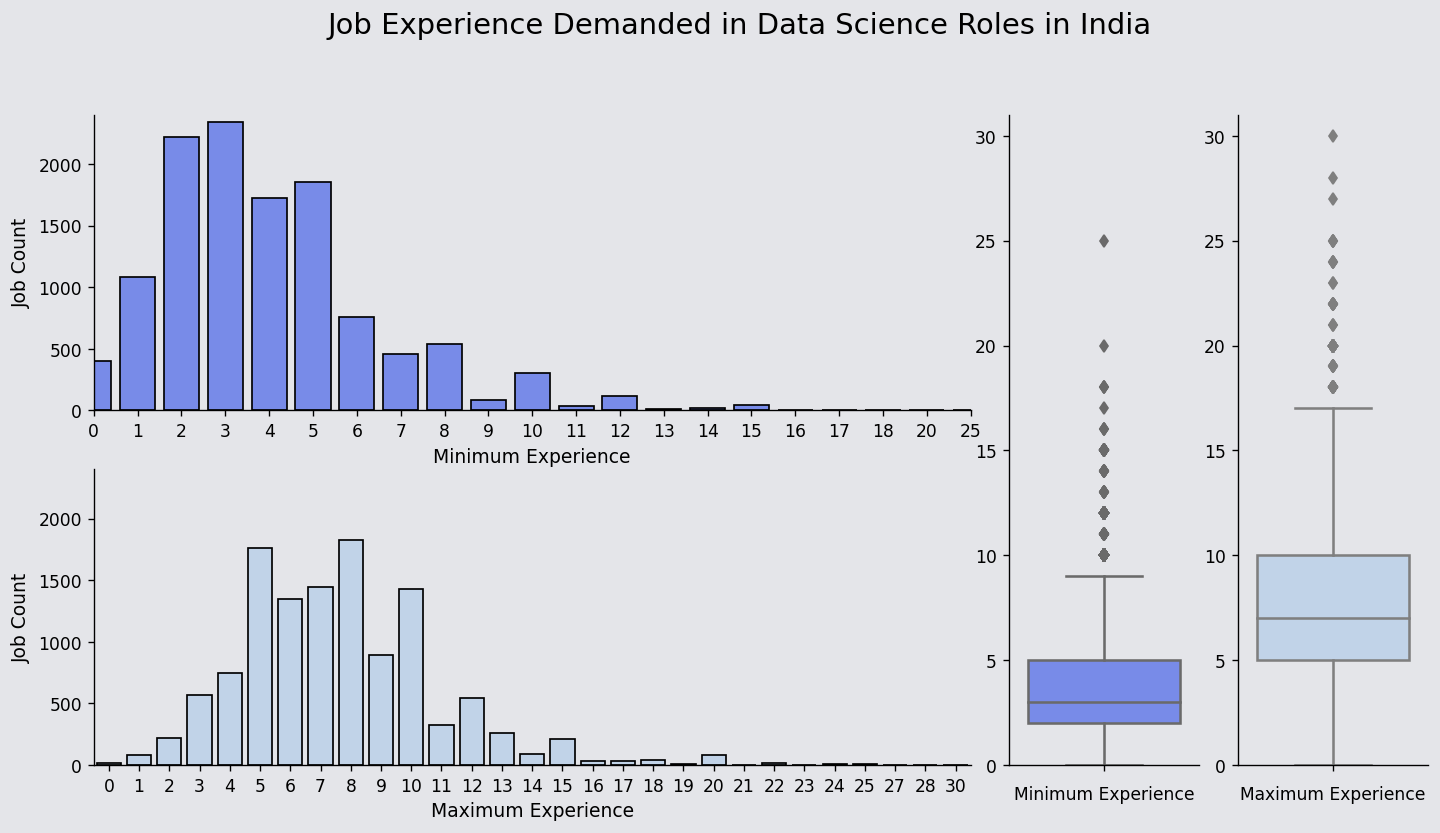

In [22]:
# plot - Job Experience Demanded in Data Science Roles in India

fig = plt.figure(figsize=(14, 7), dpi=123, facecolor='#e4e5e9')
spec = fig.add_gridspec(ncols=6, nrows=2)

ax0 = fig.add_subplot(spec[0, :4])
sns.countplot(x='Min. Exp.',data=df, color='#657ffb', edgecolor='black')
plt.ylabel("Job Count", fontsize=11)
plt.xlabel('Minimum Experience', fontsize=11)
plt.xlim(0,20)
plt.ylim(0,2400)

ax1 = fig.add_subplot(spec[1, :4])
sns.countplot(x='Max. Exp.',data=df, color='#bad2ef',  edgecolor='black')
plt.ylabel("Job Count", fontsize=11)
plt.xlabel('Maximum Experience', fontsize=11)
plt.ylim(0,2400)
# plt.xlim(0,20)

ax2 = fig.add_subplot(spec[:, 4])
sns.boxplot(y=df['Min. Exp.'], color='#657ffb')
plt.xlabel('Minimum Experience',labelpad=5, fontsize=10)
plt.ylim(0,31)
plt.ylabel('')

ax3 = fig.add_subplot(spec[:, 5])
sns.boxplot(y=df['Max. Exp.'], color='#BAD2EF')
plt.xlabel('Maximum Experience',labelpad=5, fontsize=10)
plt.ylabel('')
plt.ylim(0,31)

for ax in [ax0,ax1,ax2,ax3]:
    ax.patch.set_alpha(0.0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.suptitle('Job Experience Demanded in Data Science Roles in India', fontsize=17, y=1)
plt.show()

In [23]:
# Average Minimum Job Experience Required Top Jobs
job_list = df['Job_Role'].value_counts().iloc[:10].index.tolist()  
exp = [round(df[df['Job_Role']==job]['Min. Exp.'].mean(),2) for job in job_list]

df_job=pd.DataFrame({'Jobs':job_list, 'Average Min. Exp':exp})
df_job=df_job.sort_values('Average Min. Exp', ascending=False)
df_job

,Jobs,Average Min. Exp
3,Senior Technical Lead (Data Engineer),4.99
5,Senior Data Engineer,4.65
6,Senior Data Scientist,4.65
7,Azure Data Engineer,4.12
8,Data Engineer: Data Integration,3.97
9,Big Data Engineer,3.62
0,Data Engineer,3.53
1,Data Scientist,3.43
4,Business Analyst,2.64
2,Data Analyst,2.55


In [24]:
# job with highest requirement of minimum experience
df[df['Min. Exp.']==df['Min. Exp.'].max()]

,Job_Role,Company,Location,Job Experience,Skills/Description,Min. Exp.,Max. Exp.
8608,Sr. Principal/Director Solution Architect,IHS Markit,Gurgaon/Gurugram,25-27,"Computer science, Solution architecture, PDF, ...",25,27
